# Assignment 3: Convolutional Neural Networks

## Part 1: MLP vs. CNN

### Step 0: Import Libraries

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.utils.data import DataLoader, random_split
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

### Step 1: Data Loading & Preprocessing (11 marks)

This assignment will use the CIFAR-10 dataset (*available via torchvision.datasets*). CIFAR-10 is a smaller version of the ImageNet dataset, that contains 60,000 32×32 color images in 10 classes (airplane, automobile, bird, cat, deer, dog, frog, horse, ship, truck).

The first step is to define the transformations for the training and testing datasets. In this case, we will apply a random horizontal flip. Apply any other transformations that are required.

In [2]:
# TODO: define transforms for train and test sets (2 marks)
train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),                      # Randomly flip images horizontally
    transforms.ToTensor(),                                  # Convert to Tensor
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # Normalize RGB channels (0.5 mean and 0.5 std) 
])

test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

The next step is to load the training and testing datasets and split the training data into training and validation sets. You can consider 20% of the training dataset will be used for validation. You can use a batch size of 64 for all the datasets.

In [3]:
# TODO: Load Datasets (1 mark)
# Downloaded and Extracted CIFAR10 Data
train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=False, transform=train_transform)
test_dataset  = torchvision.datasets.CIFAR10(root='./data', train=False, download=False, transform=test_transform)

# TODO: Split train into train + validation (1 mark)
training, validation = random_split(train_dataset, [int(0.8 * len(train_dataset)), 
                                                    int(0.2 * len(train_dataset))])

# TODO: Data loaders (1 mark)
train_loader = DataLoader(training, batch_size=64, shuffle=True)
val_loader   = DataLoader(validation, batch_size=64, shuffle=False) 
test_loader  = DataLoader(test_dataset, batch_size=64, shuffle=False)

For this assignment, we will compare the performance of a feed-forward network (MLP) with a convolutional neural network (CNN). We will need to define a separate class to represent each model.

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Your MLP class should have the following minimum requirements:
- At least 3 layers with ReLU activations
- At least 500 hidden units per layer
- Softmax output layer for 10 classes

Print a summary of the model architecture (number of parameters, layer shapes)

In [5]:
# TODO: Define Neural Network Model (3 marks)
class MLP(nn.Module):
    def __init__(self, i, h, o):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(i, h),  # Connect layers together
            nn.ReLU(),        # Apply ReLU
            nn.Linear(h, h),
            nn.ReLU(),
            nn.Linear(h, h),
            nn.ReLU(), 
            nn.Linear(h, o),
        )

    def forward(self, x):
        x = x.view(x.size(0), -1)  # Flatten input
        return self.model(x)       # Pass through the network
    
# Input, Hidden, Output
D_i, D_h, D_o = 3 * 32 * 32, 500, 10
mlp_model = MLP(D_i, D_h, D_o)        # Create MLP Model

mlp_params = sum(p.numel() for p in mlp_model.parameters())  # Total number of parameters

print(mlp_model)
print("Total parameters:", mlp_params)


MLP(
  (model): Sequential(
    (0): Linear(in_features=3072, out_features=500, bias=True)
    (1): ReLU()
    (2): Linear(in_features=500, out_features=500, bias=True)
    (3): ReLU()
    (4): Linear(in_features=500, out_features=500, bias=True)
    (5): ReLU()
    (6): Linear(in_features=500, out_features=10, bias=True)
  )
)
Total parameters: 2042510


Your CNN class should have the following minimum requirements:
- At least 3 convolutional layers with ReLU activations
  - Example output for 3 layers: 32 feature maps -> 64 feature maps -> 128 feature maps
- At least 2 max-pooling layers
- At least 1 fully connected layer before the output
- Softmax output layer for 10 classes
- Use dropout to improve generalization

Print a summary of the model architecture (number of parameters, layer shapes)

In [6]:
# TODO: Define CNN Model (3 marks)
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)    # 3  ->  32 output channels
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)   # 32 ->  64 output channels
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)  # 64 -> 128 output channels
        
        self.pool = nn.MaxPool2d(2, 2)   # Decreases height and width by a factor of 2
        self.dropout = nn.Dropout(0.25)  # Dropout for regularization
        
        self.fc1 = nn.Linear(128 * 4 * 4, 256) # Flatten -> 256 neurons 
        self.fc2 = nn.Linear(256, 10)          # 256 neurons -> 10 output neurons

    def forward(self, x):
        x = F.relu(self.conv1(x))  # First convolution with ReLU
        x = self.pool(x)           # pool and reduce the size by half
        x = F.relu(self.conv2(x))
        x = self.pool(x)
        x = F.relu(self.conv3(x))
        x = self.pool(x)
        x = torch.flatten(x, 1)    # Flatten to make fully connected layer
        x = self.dropout(x)        # Apply dropout
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x
    
cnn_model = CNN().to(device)
cnn_params = sum(p.numel() for p in cnn_model.parameters())  # Total number of parameters

print(cnn_model)
print("Total parameters:", cnn_params)

CNN(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout): Dropout(p=0.25, inplace=False)
  (fc1): Linear(in_features=2048, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=10, bias=True)
)
Total parameters: 620362


### Step 3: Define Training and Testing Loops (7 marks)

Next, you will need to define the loss criterion and the optimizer. Select an appropriate criterion. For the optimizer, use Adam with a constant learning rate of 0.001.

In [7]:
# TODO: Define loss criterion and optimizer (2 marks)
# Loss Criterion
criterion = nn.CrossEntropyLoss()

# Optimizer
mlp_optimizer = optim.Adam(mlp_model.parameters(), lr=0.001)
cnn_optimizer = optim.Adam(cnn_model.parameters(), lr=0.001)

Since we are evaluating the performance of two different models, we can create functions for both the training and validation loops. For each loop, you should print the average loss and the accuracy for each epoch.

In [8]:
# TODO: Training loop (3 marks)
def train_loop(dataloader, model, loss_fn, optimizer, device):
    model.train()
    train_loss = 0.0
    correct = 0

    for X, y in dataloader:
        X, y = X.to(device), y.to(device)  # Move the data to the device being used
        output = model(X)                  # Make a prediction
        loss = loss_fn(output, y)          # Calculate Loss

        optimizer.zero_grad()  # Reset Gradients
        loss.backward()        # Determine new Gradients
        optimizer.step()       # Update Weights

        train_loss += loss.item() * y.size(0)             # Batch Loss
        pred = output.argmax(dim=1, keepdim=True)         # Get predicted class
        correct += pred.eq(y.view_as(pred)).sum().item()  # Count the number of correct predictions

    avg_loss = train_loss / len(dataloader.dataset)       # Average loss over dataset
    accuracy = correct / len(dataloader.dataset)          # Accuracy over dataset

    return avg_loss, accuracy

In [9]:
# TODO: Validation loop (2 marks)
def validation_loop(dataloader, model, loss_fn, device):
    model.eval()  # Evaluate Mode
    val_loss = 0.0
    correct = 0

    with torch.no_grad():  # No gradients computed
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            output = model(X)

            val_loss += loss_fn(output, y).item() * y.size(0)
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(y.view_as(pred)).sum().item()

    val_loss /= len(dataloader.dataset)
    accuracy = correct / len(dataloader.dataset)

    return val_loss, accuracy

### Step 4: Train, Evaluate and Visualize (11 marks)

We can also create functions for plotting the training and validation losses over the epochs and for creating a confusion matrix.

In [10]:
# TODO: Create plotting functions (2 marks)
# Function to plot the training and validation losses for comparison
def plot_losses(train_losses, val_losses):
    plt.figure(figsize=(8,6))
    plt.plot(train_losses, label='Training Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.grid(True)
    plt.show()

# Function to compute and plot the confusion matrix
def plot_matrix(dataloader, model, device, classes):
    model.eval()
    all_preds, all_labels = [], []

    # Iterate over dataloader to obtain predictions
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Display model performance for each class
    cm = confusion_matrix(all_labels, all_preds)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)
    disp.plot(xticks_rotation='vertical')
    plt.show()


Now that we have defined our required functions, we can train, evaluate and visualize the results for both models. You can use 20 epochs for both models.

In [11]:
# TODO: Run Training and validation loops for NN (2 marks)
epochs = 20

# Lists to store loss values
mlp_train_losses, mlp_val_losses = [], []
mlp_train_accs, mlp_val_accs = [], []

# Loop over a set number of epochs
print("Epoch  Train Loss  Train Accuracy  Validation Loss  Validation Accuracy")
for epoch in range(epochs):
    # Call Train and Validation loops
    train_loss, train_acc = train_loop(train_loader, mlp_model, criterion, mlp_optimizer, device)
    val_loss, val_acc = validation_loop(val_loader, mlp_model, criterion, device)

    # Add current epochs loss to lists
    mlp_train_losses.append(train_loss)
    mlp_val_losses.append(val_loss)
    mlp_train_accs.append(train_acc)
    mlp_val_accs.append(val_acc)

    print(f"{epoch+1:<7}{train_loss:<12.4f}{train_acc:<16.4f}{val_loss:<17.4f}{val_acc:<19.4f}")

Epoch  Train Loss  Train Accuracy  Validation Loss  Validation Accuracy
1      1.6952      0.3966          1.5486           0.4524             
2      1.4954      0.4708          1.4683           0.4790             
3      1.3861      0.5091          1.4116           0.5000             
4      1.3181      0.5310          1.3733           0.5167             
5      1.2519      0.5554          1.3946           0.5213             
6      1.1936      0.5737          1.3734           0.5223             
7      1.1386      0.5927          1.3538           0.5372             
8      1.0908      0.6101          1.3770           0.5360             
9      1.0385      0.6301          1.3918           0.5378             
10     1.0007      0.6379          1.4181           0.5434             
11     0.9533      0.6575          1.4281           0.5414             
12     0.9085      0.6760          1.4652           0.5382             
13     0.8616      0.6898          1.5237           0.5292      

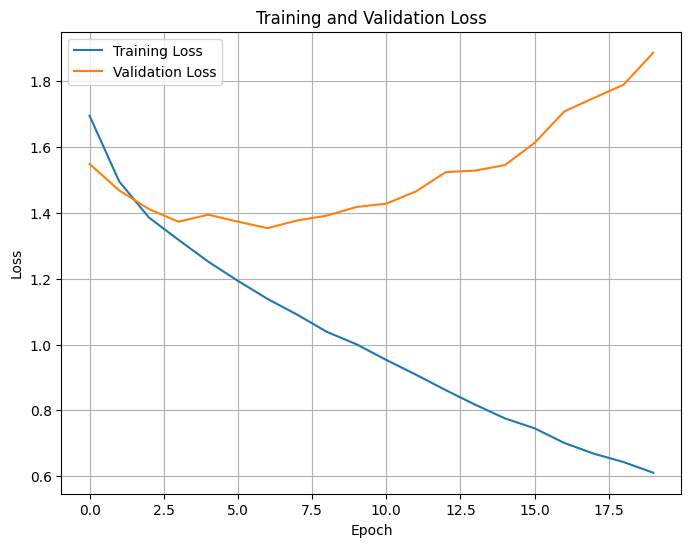

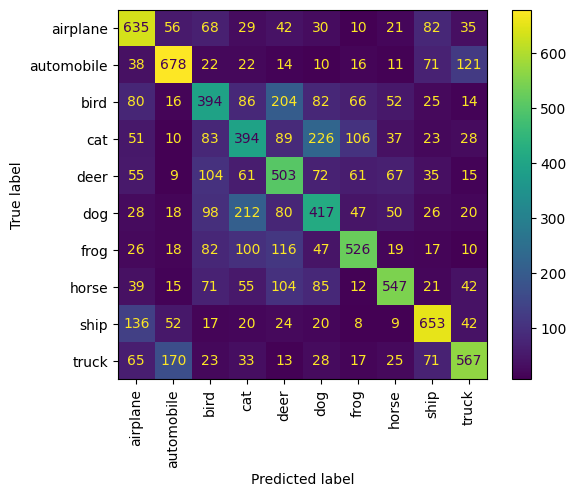

In [12]:
# TODO: Plot losses for NN (1 mark)
classes = ["airplane", "automobile", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck"]  # Class labels  

plot_losses(mlp_train_losses, mlp_val_losses)
plot_matrix(val_loader, mlp_model, device, classes)

In [13]:
# TODO: Run Training and validation loops for CNN (2 marks)
epochs = 20

# Lists to store loss values
cnn_train_losses, cnn_val_losses = [], []
cnn_train_accs, cnn_val_accs = [], []

# Loop over a set number of epochs
print("Epoch  Train Loss  Train Accuracy  Validation Loss  Validation Accuracy")
for epoch in range(epochs):
    # Call Train and Validation loops
    train_loss, train_acc = train_loop(train_loader, cnn_model, criterion, cnn_optimizer, device)
    val_loss, val_acc = validation_loop(val_loader, cnn_model, criterion, device)

    # Add current epochs loss to lists
    cnn_train_losses.append(train_loss)
    cnn_val_losses.append(val_loss)
    cnn_train_accs.append(train_acc)
    cnn_val_accs.append(val_acc)

    print(f"{epoch+1:<7}{train_loss:<12.4f}{train_acc:<16.4f}{val_loss:<17.4f}{val_acc:<19.4f}")

Epoch  Train Loss  Train Accuracy  Validation Loss  Validation Accuracy
1      1.4719      0.4639          1.1843           0.5718             
2      1.0830      0.6160          0.9953           0.6491             
3      0.9172      0.6762          0.8521           0.7024             
4      0.8092      0.7163          0.7421           0.7442             
5      0.7286      0.7428          0.7120           0.7531             
6      0.6758      0.7649          0.6941           0.7613             
7      0.6225      0.7817          0.6583           0.7702             
8      0.5836      0.7965          0.6448           0.7781             
9      0.5449      0.8072          0.6304           0.7813             
10     0.5100      0.8215          0.6394           0.7832             
11     0.4876      0.8274          0.6311           0.7852             
12     0.4501      0.8405          0.6339           0.7848             
13     0.4329      0.8485          0.6630           0.7748      

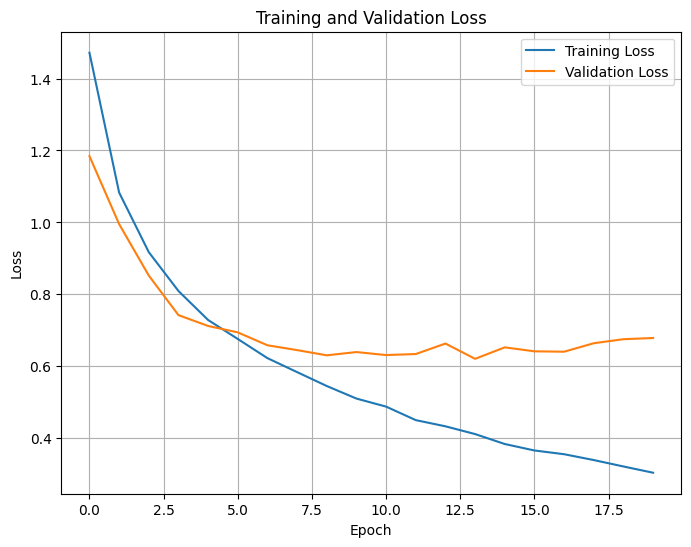

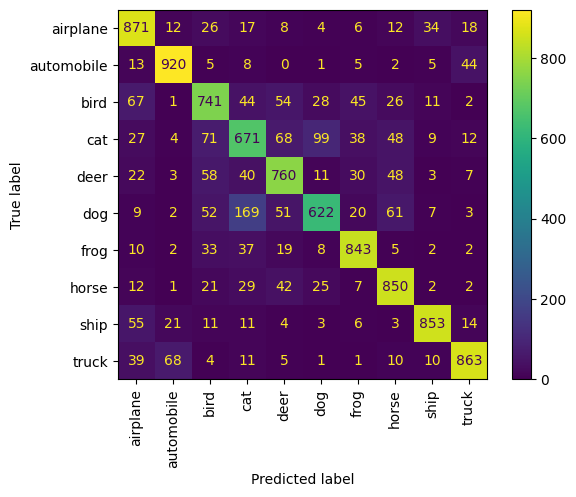

In [14]:
# TODO: Plot losses for CNN (1 mark)
classes = ["airplane", "automobile", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck"]  # Class labels

plot_losses(cnn_train_losses, cnn_val_losses)
plot_matrix(val_loader, cnn_model, device, classes)

### Step 5: Model Testing (3 marks)

Now that we have compared the two models, we can select the best one and use the testing data to see how well this model generalizes.

In [15]:
# TODO: Test loop (3 marks)
def test_loop(dataloader, model, loss_fn, device):
    model.eval()  # Evaluate mode
    test_loss = 0.0
    correct = 0

    with torch.no_grad():  # No gradients computed
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            output = model(X)

            test_loss += loss_fn(output, y).item() * y.size(0)
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(y.view_as(pred)).sum().item()

    # Determine the loss and accuracy over the dataset
    test_loss /= len(dataloader.dataset)
    accuracy = correct / len(dataloader.dataset)

    return test_loss, accuracy

In [16]:
# Evaluating the CNN model on the test dataset
test_loss, test_acc = test_loop(test_loader, cnn_model, criterion, device)

print("Test Loss  Test Accuracy")
print(f"{test_loss:<11.4f}{test_acc:<13.4f}")

Test Loss  Test Accuracy
0.7132     0.7890       


### Questions (12 marks)
1. How do your training, validation, and test accuracies compare for your best model? What does this tell you about the model's generalization?
    - We find that the best model after 20 epochs of training and validation is the CNN model. This model achieves higher accuracies compared to the MLP model, with values of 0.89 for training, 0.80 for validation, and 0.79 for testing. These results indicate that the CNN generalizes well, performing well not only on the training data but also on unseen data. The model does not appear to overfit and can correctly classify images about 79% of the time, showing us its ability to learn meaningful features from the data.

1. Examine your results for both models. Do you see signs of overfitting or underfitting? Explain what indicates this.
    - When examining the MLP model which has over 2 million parameters, we observe that the training accuracy initially increases and reaches around 0.78. However, the validation accuracy remains relatively flat throughout the 20 epochs, staying between 0.53 and 0.54. Additionally, it seen that the training loss decreases consistently, while the validation loss begins to increase around the 7th epoch, as seen in the plots. This behavior indicates that after the 7th epoch, the MLP model starts to overfit the data. It learns patterns specific to the training set but fails to generalize to unseen data, performing poorly on the validation set because it does not capture the underlying features effectively. In contrast, the CNN model which has around 620k parameters shows a different trend. Both training and validation accuracies increase steadily during training, reaching 0.89 and 0.79 respectively. Training and validation losses decrease initially, with the validation loss stabilizing around the 7th epoch and only slightly increasing afterward. These results suggest that the CNN generalizes well and does not overfit, maintaining good performance on unseen data. Overall, for the CIFAR10 dataset, the MLP model shows signs of overfitting, whereas the CNN model performs substantially better, with neither model showing signs of underfitting.

1. How can we further improve the results? Provide two suggestions.
    - One way we could improve the results of the CNN model is by experimenting with the model architecture and tuning its hyperparameters. This could involve adjusting the number of convolutional layers or filters, changing kernel sizes, changing our max pooling approach, or fine tuning the learning rate to achieve better results and generalization. Another way to improve performance is by transforming the data more using data augmentation. In addition to the RandomHorizontalFlip already used, applying random rotations can help the model learn rotation invariance, while techniques like color jittering can encourage the model to focus on object shapes and textures rather than color alone, ultimately improving results.

1. If your model performs poorly on certain classes (check your confusion matrix), what does that suggest about those images or their features?
    - When looking at the confusion matrix for both models, we can see that the diagonal elements represent correct predictions. However, off diagonal elements show where the model predicts incorrectly, which is more evident in the MLP confusion matrix. This suggests that the classes the model confuses have similar features. For example, in the CNN confusion matrix, there is a high number of misclassifications between the dog and cat classes. Since both animals share similar features, such as four legs, a tail, and similar shapes, the model sometimes predicts one as the other. In general, this indicates that models tend to perform worse on images that are structurally similar but belong to different classes, suggesting that improving feature extraction or adding more training data could help the model predict these classes better.

1. What is the role of dropout in the CNN? How might removing dropout change your results?
    - In a CNN model, dropout is a feature that randomly turns off a certain number of neurons in the fully connected layers during training. This helps reduce overfitting because the model cannot rely on specific pathways to make predictions, and instead it must learn to use all available neurons and generalize better. If dropout were to be removed, the CNN would most likely overfit the training data, showing high training accuracy but lower validation accuracy, along with a decrease in training loss and increase in validation loss. By including dropout, the model learns more robust features and performs better on unseen data.

1. What other data transformations did you include and why? Are there any other data augmentation methods that we could use for this dataset?
    - When transforming the dataset, besides converting it to tensors and performing a RandomHorizontalFlip, the data was also normalized with a mean of 0.5 and a standard deviation of 0.5. This was done for all RGB channels to allow the model to train more efficiently by keeping the input values within a specific range. Besides the transformations already done, for the CIFAR10 dataset we could also add RandomRotation and ColorJitter (as mentioned previously), along with RandomCrop or even RandomGrayscale. Using these augmentations would allow the model to avoid overfitting and learn to recognize the underlying patterns of the objects in the images, while also becoming less sensitive to variations in lighting, color, and object orientation. Because the dataset is so diverse, containing animals and vehicles, these transformations can help the model generalize better to unseen examples and focus on the shapes, textures, and other meaningful features of each object.

### Process Description (4 marks)
Please describe the process you used to create your code. Cite any websites or generative AI tools used. You can use the following questions as guidance:
1. Where did you source your code?
    - The code for this assignment was sourced from multiple places such as the examples posted on D2L, code written in Assignment 1, and lecture notes covering CNNs. Using the MNIST examples along with the feature map demo allowed me to understand how code is meant to be structured as it relates to CNNs, allowing me to build and compare the model to an MLP model.
1. In what order did you complete the steps?
    - The steps for this assignment were completed in the order they appeared, in which I completed and wrote code based on what the specific section was asking. For example, when asked to define a CNN, I used the requirements outlined and code from D2L examples to build the model and only moved on to select the criterion/optimizer after I was complete. By completing the assignment this way, it allowed me to create more reusable and simplified code.
1. If you used generative AI, what prompts did you use? Did you need to modify the code at all? Why or why not?
    - When working through this assignment, I used generative AI to help me in my understanding of MLPs and CNNs. By asking questions such as "How does max pooling help in creating more robust models?" and "How does backpropagation work for convolutional layers?" I was able to further my understanding of what is happening when using the various PyTorch functions and their usefulness.
1. Did you have any challenges? If yes, what were they? If not, what helped you to be successful?
    - By using the examples and lecture notes provided, I did not face many challenges. What helped me be successful was the constant referencing of the examples and breaking them down into their parts which I could understand and use if needed in my solutions. Using this method helped me not only to understand how to create CNNs and visualize their success but also in what ways they are better than MLPs.

## Part 2: Reflection (2 marks)
Include a sentence or two about:
- what you liked or disliked,
- found interesting, confusing, challenging, motivating while working on this assignment.
    -  This was a great assignment for reinforcing the topics learned in class as it relates to CNN and directly comparing them to what we learned previously. I found it interesting how easy it is for MLPs to overfit as compared to CNNs when dealing with images, and I look forward to learning about other types of models we can create for different applications.